In [1]:
from SpaceNet import *
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import random
import shapely

In [2]:
#here we take MI as an example, and we have got the celltrek results already
#the chosen spots were saved in st_adata.obs['area'], if not, please define your ROI first
st_adata = sc.read('../stdata/MI_stadata.h5ad')
st_adata.var_names_make_unique()
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)

sc_adata = sc.read('../scdata/MI/sc_adata_raw.h5ad')
sc_adata.var_names_make_unique()
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

df_ck = pd.read_csv('../celltrek/MI_celltrek.csv')
df_ck = df_ck[['cell_type', 'coord_x', 'coord_y']]

In [3]:
st_adata

AnnData object with n_obs × n_vars = 4451 × 36601
    obs: 'area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    obsm: 'spatial'

In [4]:
df_ck

,cell_type,coord_x,coord_y
0,lymphoid lineage restricted progenitor cell,7431.457840,1027.679411
1,lymphoid lineage restricted progenitor cell,7476.162829,1050.311631
2,lymphoid lineage restricted progenitor cell,7468.236488,1011.104838
3,cardiac endothelial cell,2350.286952,6129.206759
4,cardiac endothelial cell,2427.148589,6111.908661
...,...,...,...
10621,smooth muscle myoblast,6645.405057,7201.168874
10622,immature innate lymphoid cell,6824.818226,5665.182301
10623,cardiac muscle myoblast,5414.267485,1702.542265
10624,cardiac muscle myoblast,5348.032896,1744.949759


In [5]:
search_factor = 1
spotradius = float(cal_spot_radius(st_adata.obsm['spatial']))
cg, radius = generate_search_range(st_adata, radius=spotradius*search_factor, disease_metric_key='area', search_factor=search_factor)

In [6]:
cg

In [7]:
df_ck['isinarea'] = [cg.contains(shapely.Point(x)) for x in df_ck[['coord_x', 'coord_y']].values]

In [8]:
df_in = df_ck[df_ck['isinarea'] == True]['cell_type'].value_counts()
df_total = df_ck['cell_type'].value_counts()
df_sta = pd.DataFrame([df_in, df_total])
df_sta.loc['prop'] = df_sta.iloc[0].div(df_sta.iloc[1])
df_sta = df_sta.sort_values(by='prop', axis=1, ascending=False)
#df_sta.to_csv('../results/MI_ct_enriched_celltrek.csv')

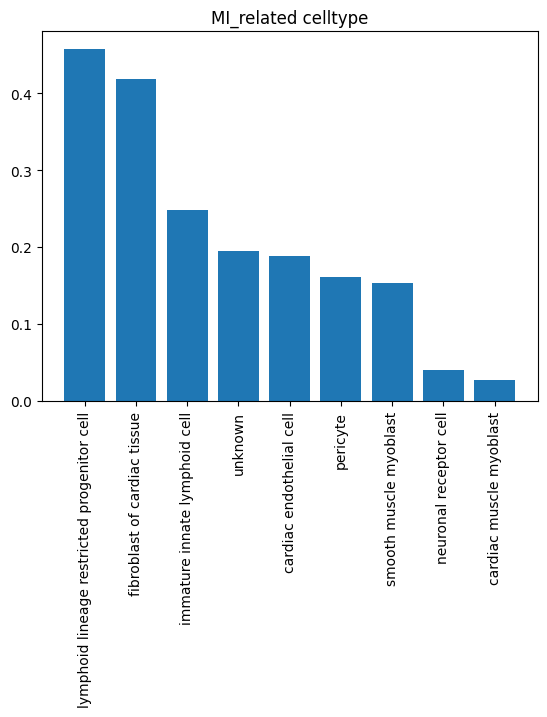

In [9]:
plt.bar(x=df_sta.columns, height=df_sta.loc['prop'])
plt.xticks(rotation=90)
plt.title('MI_related celltype')
plt.show()

In [10]:
#selected_ROI support mode='wilcoxon' only
st_adata = cal_gene_enrichment(st_adata, disease_metric_key='area', log=False, mode='wilcoxon')

In [11]:
#enriched_genes = cal_enriched_genes(adata, pval_adj=0.05) #select genes with p-value
enriched_genes = cal_enriched_genes(st_adata, top_g=50, bottom_g=50) # OR select genes with enrichment_score (z-score)
#enriched_genes.to_csv('adl_abetaenriched_genes.csv') #save your genes enriched in ROI

In [12]:
enriched_genes

,gene_ids,feature_types,genome,gene_enrichment,pvals,pvals_adj
COL1A2,ENSG00000164692,Gene Expression,GRCh38,40.814007,0.000000e+00,0.000000e+00
COL3A1,ENSG00000168542,Gene Expression,GRCh38,40.632111,0.000000e+00,0.000000e+00
COL1A1,ENSG00000108821,Gene Expression,GRCh38,40.400021,0.000000e+00,0.000000e+00
SPARC,ENSG00000113140,Gene Expression,GRCh38,39.051418,0.000000e+00,0.000000e+00
EEF1A1,ENSG00000156508,Gene Expression,GRCh38,36.373756,1.106980e-289,3.376383e-286
...,...,...,...,...,...,...
MT-ND3,ENSG00000198840,Gene Expression,GRCh38,-38.639877,0.000000e+00,0.000000e+00
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,-39.101147,0.000000e+00,0.000000e+00
MT-CO1,ENSG00000198804,Gene Expression,GRCh38,-39.173264,0.000000e+00,0.000000e+00
MT-ND1,ENSG00000198888,Gene Expression,GRCh38,-40.086971,0.000000e+00,0.000000e+00


In [13]:
query_result, query_failed = query(protein_list=enriched_genes.index, 
                                   species='Homo sapiens', #supported species: Homo sapiens, Mus musculus, Rattus norvegicus
                                   db_path='../string/', 
                                   score_threshold=700) 
query_result = query_result.reset_index(drop=True)
query_result = cal_genecoexp(st_adata, query_result)
#query_result.to_csv('abeta_spacenet.csv')

In [14]:
query_result

,node_1,protein1,node_2,protein2,combined_score,coexpef
0,RPL18A,9606.ENSP00000222247,RPL13A,9606.ENSP00000375730,999.0,0.331958
1,RPL18A,9606.ENSP00000222247,TPT1,9606.ENSP00000477781,945.0,0.257319
2,RPL18A,9606.ENSP00000222247,RPS3A,9606.ENSP00000346050,999.0,0.209982
3,RPL18A,9606.ENSP00000222247,RPS11,9606.ENSP00000270625,999.0,0.268394
4,RPL18A,9606.ENSP00000222247,RPL3,9606.ENSP00000346001,999.0,0.302901
...,...,...,...,...,...,...
905,TNNT2,9606.ENSP00000499593,LDB3,9606.ENSP00000401437,882.0,0.447306
906,TNNT2,9606.ENSP00000499593,TTN,9606.ENSP00000467141,857.0,0.571615
907,TNNT2,9606.ENSP00000499593,MYL2,9606.ENSP00000228841,950.0,0.536673
908,TNNT2,9606.ENSP00000499593,MYBPC3,9606.ENSP00000442795,974.0,0.386437


In [15]:
expression_sums, expression_ratios = calculate_gene_expression_by_celltype(sc_adata, 'cell_type')

In [16]:
expression_ratios

,cardiac endothelial cell,cardiac muscle myoblast,fibroblast of cardiac tissue,immature innate lymphoid cell,lymphoid lineage restricted progenitor cell,neuronal receptor cell,pericyte,smooth muscle myoblast,unknown
TSPAN6,0.423926,0.019345,0.380707,0.049767,0.029899,0.000000,0.057197,0.011724,0.027435
DPM1,0.195946,0.150254,0.201633,0.337164,0.035416,0.004090,0.050642,0.009011,0.015844
SCYL3,0.175667,0.082839,0.230561,0.376449,0.048181,0.003076,0.049481,0.012180,0.021565
FIRRM,0.168154,0.065828,0.165133,0.465876,0.028331,0.001549,0.033161,0.008105,0.063864
FGR,0.042850,0.003274,0.020799,0.884347,0.017550,0.000000,0.003857,0.000528,0.026795
...,...,...,...,...,...,...,...,...,...
H2BC6-AS1,0.104439,0.137463,0.168896,0.477454,0.080362,0.000000,0.000000,0.000000,0.031385
MGC4859,0.087725,0.260613,0.238831,0.313792,0.024648,0.010136,0.043525,0.000000,0.020730
H2AC19,0.066424,0.380454,0.103948,0.324115,0.125059,0.000000,0.000000,0.000000,0.000000
HOMEZ,0.166227,0.106795,0.183597,0.441068,0.040302,0.011561,0.028307,0.004258,0.017885


In [17]:
selected_genes = list(enriched_genes.index) #select genes enriched in ROI as calcuted before
gene_ct_net = construct_gene_ct_net(expression_ratios=expression_ratios, selected_genes=selected_genes)
#gene_ct_net.to_csv('gene_ct_net.csv')
gene_ct_net

,node1,node2,ratio
0,DCN,cardiac endothelial cell,0.073557
1,MDH1,cardiac endothelial cell,0.113957
2,VIM,cardiac endothelial cell,0.255828
3,TMSB10,cardiac endothelial cell,0.291973
4,VCAN,cardiac endothelial cell,0.189712
...,...,...,...
877,COL5A2,unknown,0.018352
878,MT-ND4L,unknown,0.013108
879,MT-ATP8,unknown,0.017191
880,RPS18,unknown,0.019279
